In [1]:
import numpy as np
import matplotlib.pyplot as plt
#from scipy.sparse import coo_array
import pandas as pd

from scipy.sparse import coo_matrix
from scipy.sparse.linalg import spsolve

In [2]:
import CurvilinearFEM_Trial_2D as FEM


In [3]:
H_total=2

In [4]:

alphas=[FEM.custom_function_2d_vector(lambda xy: np.array( [xy[0],xy[1]]),
                                      lambda xy: np.array( [[1,0],[0,1]]),
                                 lambda st: np.array( [st[0],st[1]]),
                                 lambda st:  np.array([[[0,0],[0,0]],[[0,0],[0,0]]]),
                          "identity"),
        FEM.custom_function_2d_vector(lambda xy:  np.array([(xy[0]+1)**2,(xy[1]+1)**2]),
                                      lambda xy:  np.array([[(xy[0]+1)*2,0],[0,(xy[1]+1)*2]]),
                                 lambda st:  np.array([st[0]**0.5-1,st[1]**0.5-1]),
                                 lambda st:  np.array([[[-0.25*st[0]**(-1.5),0],[0,0]],[[0,0],[0,-0.25*st[1]**(-1.5)]]]),
                          "square"),
        FEM.custom_function_2d_vector(lambda xy: np.array( [(xy[0]+1)**3,(xy[1]+1)**3]),
                                      lambda xy: np.array( [[3*(xy[0]+1)**2,0],[0,3*(xy[1]+1)**2]]),
                                 lambda st: np.array( [st[0]**(1/3)-1,st[1]**(1/3)-1]),
                                 lambda st: np.array( [[[-2/9*st[0]**(-5/3),0],[0,0]],[[0,0],[0,-2/9*st[1]**(-5/3)]]]),
                          "cube"),
        FEM.custom_function_2d_vector(lambda xy: np.array( [xy[0],-np.log(2*H_total-xy[1])]),
                                      lambda xy: np.array( [[1,0],[0,1/(2*H_total-xy[1])]]),
                          lambda st:np.array(   [st[0],2*H_total-np.exp(-st[1])]), 
                                 lambda st: np.array( [[[0,0],[0,0]],[[0,0],[0,-np.exp(-st[1])]]]), 
                          "Xlinear-Ylog"),
       #  FEM.custom_function_2d_vector(lambda xy:  np.array([xy[0],(xy[1]+1)**2]),
       #                                lambda xy: np.array( [[1,0],[0,(xy[1]+1)*2]]),
       #                    lambda st:  np.array( [st[0],st[1]**0.5-1]), 
       #                           lambda st: np.array( [[[0,0],[0,0]],[[0,0],[0,-0.25*st[1]**(-1.5)]]]),
       #                    "Xlinear-Ysquare"),
       #  FEM.custom_function_2d_vector(lambda xy: np.array( [xy[0],(H_total*xy[1]-0.5*xy[1]**2)]),
       #                                lambda xy: np.array( [[1,0],[0,H_total-xy[1]]]),
       #                    lambda st:np.array(   [st[0],H_total-np.sqrt(H_total**2-2*st[1])]), 
       #                           lambda st: np.array( [[[0,0],[0,0]],[[0,0],[0,(H_total**2-2*st[1])**(-1.5)]]]), 
       #                    "Xlinear-Ysquare2"),
        FEM.custom_function_2d_vector(lambda xy: np.array( [xy[0],np.sin(xy[1])]),
                                      lambda xy: np.array( [[1,0],[0,np.cos(xy[1])]]),
                          lambda st:np.array(   [st[0],np.arcsin(st[1])]), 
                                 lambda st: np.array( [[[0,0],[0,0]],[[0,0],[0,st[1]*(1-st[1]**2)**(-1.5)]]]), 
                          "Xlinear-Ysin")]

In [5]:
N_divisions = 10
alpha = FEM.custom_function_2d_vector(lambda xy: np.array( [xy[0],(H_total*xy[1]-0.5*xy[1]**2)]),
                                      lambda xy: np.array( [[1,0],[0,H_total-xy[1]]]),
                          lambda st:np.array(   [st[0],H_total-np.sqrt(H_total**2-2*st[1])]), 
                                 lambda st: np.array( [[[0,0],[0,0]],[[0,0],[0,(H_total**2-2*st[1])**(-1.5)]]]), 
                          "Xlinear-Ysquare2")#RMSE=0.0000000001782301
# alpha =FEM.custom_function_2d_vector(lambda xy: np.array( [xy[0],xy[1]]),
#                                       lambda xy: np.array( [[1,0],[0,1]]),
#                                  lambda st: np.array( [st[0],st[1]]),
#                                  lambda st:  np.array([[[0,0],[0,0]],[[0,0],[0,0]]]),
#                           "identity")#RMSE=0.0000000002611099

alpha = [alpha for alpha in alphas if alpha.name=="cube"][0]
print(alpha.name)

cube


In [6]:
class UniformMaterial:
    def __init__(self,**kwargs):
        self.Youngs_modulus=200*10**9#Pa
        self.Poisson_Ratio=0.3#0.3# No units
        self.Rho=7850#kg/m^3
        if "Youngs_modulus" in kwargs:
            self.Youngs_modulus=kwargs["Youngs_modulus"]
        if "Poisson_Ratio" in kwargs:
            self.Poisson_Ratio=kwargs["Poisson_Ratio"]
        if "Rho" in kwargs:
            self.Rho=kwargs["Rho"]
        self.mu=self.Youngs_modulus/(2*(1+self.Poisson_Ratio))
        self.lam=self.Poisson_Ratio*self.Youngs_modulus/((1+self.Poisson_Ratio)*(1-2*self.Poisson_Ratio))

mat=UniformMaterial()

In [7]:
def write_coor_image(N_divisions, N_ele,cny,xy_coor,st_coor,name,bool_display=True):
    ### Block: write coordinate system
    ### Input: N_divisions, N_ele,cny,xy_coor,st_coor,alpha.name
    ### output: None (image exported)
    #create the mesh on xy and st plane
    fig, ax = plt.subplots(1,2,figsize=(10,5))
    for i in range(N_ele):
        node_ids=cny[i]
        for indeces in [(0,1),(1,3),(2,3),(0,2)]:
            ax[0].plot(xy_coor[node_ids[indeces,],0],xy_coor[node_ids[indeces,],1],c='black')
            ax[1].plot(st_coor[node_ids[indeces,],0],st_coor[node_ids[indeces,],1],c='black')
    # set the title 
    ax[0].set_title(f'Coordinate system "{name}" on cartesian')
    ax[1].set_title(f'Coordinate system "{name}" on st coordinates')
    #fix the aspect ratio
    plt.gca().set_aspect('equal', adjustable='box')
    # set the limit [0,1]^2
    ax[0].set_xlim(0,1)
    ax[0].set_ylim(0,1)
    plt.tight_layout()
    plt.savefig(f'Figure/coor_shape_{name}_{N_divisions}.png')
    if bool_display:
        plt.show()
    else:
        plt.close()

def calculate_integral_point(N_st, N_derivatives_st, node_coordinates, Lame_lambda, Lame_mu, force,alpha):
    ### calculate integral for this gauss point
    ### input : N_st, N_derivatives_st, node_coordinates, Lame_lambda, Lame_mu, force, alpha
    ### output : K_temp, f_temp
    N_nodes_e=N_st.size

    # Calculate the coordinates
    st=N_st@node_coordinates
    xy=alpha.inverse(st)

    # Prepare storage of variables
    K_temp = np.zeros((N_nodes_e*2,N_nodes_e*2))

    # Jacobian # 
    J = alpha.prime(xy) # J^st_xy
    basis_vector_st = np.linalg.inv(J) # e_s,e_t
    # inv_det_J=np.linalg.det(basis_vector_st)
    
    #Christoffel symbols
    Gamma = alpha.Christoffel_symbols(st)

    J2=np.linalg.inv(N_derivatives_st.T@node_coordinates)
    
    #First, gather the epsilons.
    epsilon_v = np.zeros((N_nodes_e*2,2,2))
    for i_node in range(N_nodes_e):
        for j_index in range(2):# j_index = 0(s), 1(t)
            #                 N_i * Gamma^l_jk (k=s,t, l=x,y)
            epsilon_v_temp = N_st[i_node] * Gamma[j_index,:,:]
            #         J^(zeta,eta)_(s,t) [ ∂N_i/∂zeta, ∂N_i/∂eta].T @ [(e_j)x, (e_j)y]
            epsilon_v_temp += J2@N_derivatives_st[i_node,:,None] @ basis_vector_st[j_index,None,:]
            epsilon_v_temp = J@epsilon_v_temp
            epsilon_v[i_node*2+j_index,:,:] = (epsilon_v_temp+epsilon_v_temp.T)*0.5
        
    sigma_u = np.zeros((N_nodes_e*2,2,2))
    for i_node in range(N_nodes_e):
        for j_index in range(2):#j_index=0(s),1(t)
            sigma_u[i_node*2+j_index,:,:] = \
                Lame_lambda*np.trace(epsilon_v[i_node*2+j_index,:,:])*np.eye(2)+\
                2*Lame_mu*epsilon_v[i_node*2+j_index,:,:]
    
    for i_node in range(N_nodes_e*2):
        for i_node_2 in range(N_nodes_e*2):
            K_temp[i_node,i_node_2] = np.sum(sigma_u[i_node,:,:]*epsilon_v[i_node_2,:,:])
    

    # Note: The force is in the xy coordinates
    #       so we need to transform it to the st coordinates
    force_st = basis_vector_st @ force# 2x2, 2x1 -> 2x1 
    f_temp = np.zeros(N_nodes_e*2)
    for i_node in range(N_nodes_e):
        f_temp[i_node*2:i_node*2+2] = N_st[i_node]*force_st
    
    return K_temp, f_temp

def extract_Ax_b(N_unknown, N_dofs, K, f_vector, u_BC, u_value):
    ### Extrarct the equation for the unknown variables
    ### inputs : N_unknown, N_dofs, K, f_vector, u_BC, u_value
    ### outputs : A, b
    A_row=[]
    A_col=[]
    A_values=[]

    b=np.zeros(N_unknown)

    for ind in range(N_dofs):
        i=u_BC[ind]
        if i==-1:
            continue
        b[i]=f_vector[ind]
        for ptr in range(K.indptr[ind],K.indptr[ind+1]):
            i2=K.indices[ptr]
            if u_BC[i2]!=-1:
                if K.data[ptr]==0.0:
                    continue
                A_values.append(K.data[ptr])
                A_row.append(i)
                A_col.append(u_BC[i2])
            else:
                b[i]-=K.data[ptr]*u_value[i2]
        
    A=coo_matrix((A_values, (A_row, A_col)), shape=(N_unknown, N_unknown)).tocsr()
    return A, b

def calculate_external_force(Nx_divisions, Ny_divisions, N_dofs, cny, cny_dummy, st_coor, N_1D, force, alpha, gauss_points, gauss_weights, d_x, H_upper):
    ### Block : Calculate external force
    ### inputs : Nx_divisions, Ny_divisions, N_dofs, cny, cny_dummy, st_coor, N_1D, force, alpha, gauss_points, gauss_weights, d_x, H_upper
    ### outputs : f_external_vector
    # Add external forces on the top
    f_external_vector=np.zeros(N_dofs)
    for i_x in np.arange(Nx_divisions):
        i_ele=(Ny_divisions-1)*Nx_divisions+i_x
        # Element 
        node_ids= cny[i_ele][2:]
        node_dummy_ids= cny_dummy[i_ele][2:]

        indeces=np.zeros(2*2,dtype=int)
        indeces[0::2]=node_dummy_ids*2
        indeces[1::2]=node_dummy_ids*2+1
        
        # Element coordinates
        node_coordinates = st_coor[node_ids]
        for i_zeta_gauss in range(gauss_weights.size):
            zeta_gauss = gauss_points[i_zeta_gauss]

            N_st=N_1D(zeta_gauss)
            st=N_st@node_coordinates

            #prepare collection of variables
            F_temp = np.zeros(2*2)

            # Jacobian # 
            xy=alpha.inverse(st)
            J = alpha.prime(xy) # J^st_xy
            #print(J)
            basis_vector_st = np.linalg.inv(J) # e_s,e_t
    
            force_st = basis_vector_st @ force# 2x2, 2x1 -> 2x1 
            for i_node in range(2):
                F_temp[i_node*2:i_node*2+2] = N_st[i_node]*force_st
            f_external_vector[indeces] += F_temp*gauss_weights[i_zeta_gauss]*d_x*H_upper
    
    return f_external_vector

def calculate_RMSE(Nx_divisions, Ny_divisions, u_value, cny, st_coor,N,alpha,gauss_points, gauss_weights, f_analytical, d_x, d_y,W,H):
    ### block : Calculate RMSE
    ### inputs : Nx_divisions, Ny_divisions, u_value, cny, st_coor, N, alpha, gauss_points, gauss_weights, f_analytical, d_x, d_y, W, H
    ### outputs : RMSE
    N_nodes_e=N(0,0).size
    SE_distribution=np.zeros(Nx_divisions*Ny_divisions)
    for i_y in range(Ny_divisions):
        for i_x in range(Nx_divisions):
            i_ele=i_y*Nx_divisions+i_x

            # Element 
            node_ids= cny[i_ele]
            
            # Element coordinates
            node_coordinates = st_coor[node_ids]
            node_coordinates_xy= alpha.inverse(node_coordinates.T).T

            indeces=np.zeros(N_nodes_e*2,dtype=int)
            indeces[0:N_nodes_e*2:2]=node_ids*2
            indeces[1:N_nodes_e*2:2]=node_ids*2+1

            u_values_local=u_value[indeces].reshape((4,2))

            SE_local=0.0
            for i_zeta_gauss in range(gauss_weights.size):
                for i_eta_gauss in range(gauss_weights.size):
                    zeta_gauss = gauss_points[i_zeta_gauss]
                    eta_gauss = gauss_points[i_eta_gauss]

                    N_st=N(zeta_gauss,eta_gauss)

                    #Gaussians on xy coordinates
                    # xy=N_st@node_coordinates_xy
                    # st=alpha.function(xy)
                    # zeta_st=(st[0]-node_coordinates[0,0])/(node_coordinates[1,0]-node_coordinates[0,0])
                    # eta_st=(st[1]-node_coordinates[0,1])/(node_coordinates[2,1]-node_coordinates[0,1])
                    # N_st=N(zeta_st,eta_st)

                    u_st_local=N_st@u_values_local
                    st=N_st@node_coordinates
                    xy=alpha.inverse(st)
                    e_basis_local=np.linalg.inv(alpha.prime(xy))
                    
                    u_local=e_basis_local@u_st_local### Note: might be e_basis_local.T@u_st_local
                    
                    u_analytical_local=np.array([0,f_analytical(xy)])
                    
                    A=calculate_area(node_coordinates)
                    inv_det_J=np.linalg.det(e_basis_local)
                    
                    #SE_local+=((u_local[0]-u_analytical_local[0])**2+(u_local[1]-u_analytical_local[1])**2)*gauss_weights[i_zeta_gauss]*gauss_weights[i_eta_gauss]*d_x*d_y
                    SE_local+=((u_local[0]-u_analytical_local[0])**2+(u_local[1]-u_analytical_local[1])**2)*gauss_weights[i_zeta_gauss]*gauss_weights[i_eta_gauss]*A*inv_det_J
            SE_distribution[i_ele]=SE_local
    return np.sqrt(SE_distribution.sum()/(W*H)),np.sqrt(SE_distribution)       # RMSE

def creat_rectangular_cyclic_mesh(Nx, Ny, Nx_divisions, Ny_divisions, d_x, d_y, N_nodes, N_ele):
    ### Definition of rectangular mesh
    ### inputs: Nx, Ny, Nx_divisions, Ny_divisions, d_x, d_y, N_nodes, N_ele
    ### outputs: xy_coor, st_coor, cny, cny_dummy
    xy_coor=np.empty((N_nodes,2),float)
    cny=np.empty((N_ele,4),int)

    for i_y in range(Ny):
        xy_coor[i_y*Nx:(i_y+1)*Nx,1]=i_y*d_y

    for i_x in range(Nx):
        xy_coor[i_x::Nx,0]=i_x*d_x

    for i_y in range(Ny_divisions):
        for i_x in range(Nx_divisions):
            i_ele=i_x+i_y*Nx_divisions
            cny[i_ele,0]=i_x   + i_y * Nx
            cny[i_ele,1]=i_x+1 + i_y * Nx
            cny[i_ele,2]=i_x   + (i_y+1) * Nx
            cny[i_ele,3]=i_x+1 + (i_y+1) * Nx
        
    cny_dummy=cny.copy()
    for i_y in range(Ny_divisions):
        cny_dummy[(i_y+1)*Nx_divisions-1,1]=i_y * Nx
        cny_dummy[(i_y+1)*Nx_divisions-1,3]=(i_y+1) * Nx

    return xy_coor, cny, cny_dummy

def create_boundary_conditions(Nx, Ny, N_dofs):
    ### Block : Apply boundary conditions
    ### inputs: N_dofs, Nx, Ny
    ### outputs: u_value, u_BC, N_unknown
    u_value=np.zeros(N_dofs,dtype=float)
    u_BC=np.zeros(N_dofs,dtype=int)

    for i in range(1,Ny):
        # Fix the left side (fix x displacement)
        u_value[i*Nx*2]=0
        u_BC[i*Nx*2]=-1

        #Fix the right side (fix x displacement)
        u_value[(i+1)*Nx*2-2]=0
        u_BC[(i+1)*Nx*2-2]=-1

    # Fix the bottom side (fix x and y displacement)
    for i in range(Nx):
        u_value[i*2]=0
        u_value[i*2+1]=0
        u_BC[i*2]=-1
        u_BC[i*2+1]=-1

    # Define cyclic boundary
    for i in range(1,Ny):
        #Fix the right side (fix y displacement as cyclic boundary)
        u_BC[(i+1)*Nx*2-1]=-1

    N_known=-np.sum(u_BC)# count known values
    N_unknown=N_dofs-N_known

    # numerate the unknown variables.
    count=0
    for i in range(N_dofs):
        if u_BC[i]!=-1:
            u_BC[i]=count
            count+=1
    
    return u_value, u_BC, N_unknown

def calculate_area(node_coordinates):
    extended=np.concatenate([node_coordinates[(0,1,3,2),:],node_coordinates[(0,),:]])
    a=extended[:4,0]*extended[1:,1]-extended[1:,0]*extended[0:4,1]
    return 0.5*np.abs(a.sum()) 

def run(N_divisions,alpha,H_total=2.0,bool_write_coor_image=False,bool_display=False, bool_write=False):
    ### Block 1 : definition of material constants
    ### inputs: None
    ### outputs: Youngs_modulus, Poisson_Ratio, Rho, Lame_mu, Lame_lambda, force

    #Definition of mechanical properties of the continuum
    Youngs_modulus=200*10**9#Pa
    Poisson_Ratio=0.3#0.3# No units
    Rho=7850#kg/m^3
    Lame_mu=Youngs_modulus*0.5/(1+Poisson_Ratio)#Pa
    Lame_lambda=Youngs_modulus*Poisson_Ratio/(1+Poisson_Ratio)/(1-2*Poisson_Ratio)#Pa
    force=Rho*np.array([0,-9.81])

    ### Block 2 : definition of mesh constants
    ### inputs: N_divisions
    ### outputs: W, H, Nx_divisions, Ny_divisions, Nx, Ny, d_x, d_y, N_nodes, N_ele
    W, H = 1.0, 1.5 # H=1.5: H1_5
    Nx_divisions = N_divisions
    Ny_divisions = N_divisions
    Nx = Nx_divisions + 1
    Ny = Ny_divisions + 1
    d_x = W/Nx_divisions
    d_y = H/Ny_divisions
    N_nodes=Nx*Ny
    N_ele=Ny_divisions*Nx_divisions

    ### Block 3 : definition of mesh
    xy_coor, cny, cny_dummy=creat_rectangular_cyclic_mesh(Nx, Ny, Nx_divisions, Ny_divisions, d_x, d_y, N_nodes, N_ele)
    st_coor=alpha.function(xy_coor.T).T

    ### Block 4 : definition of Gussian integration parameters
    ### inputs: None
    ### outputs: gauss_points, gauss_weights, N_gauss_points

    # Gauss points and weights
    # https://en.wikipedia.org/wiki/Gaussian_quadrature
    gauss_points = (np.array([-np.sqrt(5+2*np.sqrt(10/7))/3,-np.sqrt(5-2*np.sqrt(10/7))/3, 0, 
                                  np.sqrt(5-2*np.sqrt(10/7))/3,np.sqrt(5+2*np.sqrt(10/7))/3])+1.0)*0.5
    gauss_weights = np.array([(322-13*np.sqrt(70))/900, (322+13*np.sqrt(70))/900, 128/225, 
                              (322+13*np.sqrt(70))/900, (322-13*np.sqrt(70))/900])*0.5
    # gauss_points = (np.array([-np.sqrt(3/5), 0,np.sqrt(3/5)])+1.0)*0.5
    # gauss_weights = np.array([5/9, 8/9, 5/9])*0.5
    N_gauss_points = gauss_points.size

    ### Block 5 : definition of shape functions
    ## inputs: None
    ## outputs: N_nodes_e, N, N_derivatives, N_1D

    # Shape functions : s,t\in[0,1]
    N=lambda zeta,eta: np.array([(1-zeta)*(1-eta),  zeta*(1-eta),(1-zeta)*eta,  zeta*eta])
    N_derivatives=lambda zeta,eta: np.array( [ [eta-1,zeta-1],[1-eta,-zeta],[-eta,1-zeta],[eta,zeta]])
    N_nodes_e=N(0,0).size #4

    # shape function for boundary
    N_1D=lambda zeta: np.array([1-zeta,  zeta])

    ### Block 6 : definition of the global stiffness matrix and force vector
    ### inputs: N_nodes, N_ele, N_nodes_e, Nx_divisions, Ny_divisions, st_coor,cny,cny_dummy, gauss_points, gauss_weights, d_x, d_y, Lame_lambda, Lame_mu, force, N, N_derivatives, alpha
    N_dofs=N_nodes*2
    K_row=np.empty((N_ele*(N_nodes_e*2)**2),dtype=int)
    K_col=np.empty((N_ele*(N_nodes_e*2)**2),dtype=int)
    K_values=np.empty((N_ele*(N_nodes_e*2)**2),dtype=float)
    f_vector=np.zeros(N_dofs)

    for i_y in range(Ny_divisions):
        for i_x in range(Nx_divisions):
            i_ele=i_y*Nx_divisions+i_x

            # Element 
            node_ids= cny[i_ele]
            node_dummy_ids= cny_dummy[i_ele]
            
            # Element coordinates
            node_coordinates = st_coor[node_ids]
            node_coordinates_xy = xy_coor[node_ids]

            K_e = np.zeros((N_nodes_e*2,N_nodes_e*2))
            f_e = np.zeros(N_nodes_e*2)
            for i_zeta_gauss in range(gauss_points.size):
                for i_eta_gauss in range(gauss_points.size):
                    
                    zeta_gauss = gauss_points[i_zeta_gauss]
                    eta_gauss = gauss_points[i_eta_gauss]
                    
                    # Gaussians on st coordinate system.
                    N_st=N(zeta_gauss,eta_gauss)
                    N_derivatives_st=N_derivatives(zeta_gauss,eta_gauss)

                    #Gaussians on xy coordinates
                    xy=N_st@node_coordinates_xy
                    inv_det_J=np.linalg.det(np.linalg.inv(alpha.prime(xy)))
                    # st=alpha.function(xy)
                    # zeta_st=(st[0]-node_coordinates[0,0])/(node_coordinates[1,0]-node_coordinates[0,0])
                    # eta_st=(st[1]-node_coordinates[0,1])/(node_coordinates[2,1]-node_coordinates[0,1])
                    # N_st=N(zeta_st,eta_st)
                    # N_derivatives_st=N_derivatives(zeta_st,eta_st)
                    # print(f'{st=}')
                    # print(f'{node_coordinates=}')
                    # print(f'{zeta_st=}, {eta_st=}')

                    ### calculate integral for this gauss point
                    K_temp, f_temp = calculate_integral_point(N_st, N_derivatives_st, node_coordinates, Lame_lambda, Lame_mu, force,alpha)

                    A=calculate_area(node_coordinates)
                    #summup to the element stiffness matrix
                    local_weight=gauss_weights[i_zeta_gauss]*gauss_weights[i_eta_gauss]*A*inv_det_J#*d_x*d_y#*inv_det_J
                    K_e += K_temp*local_weight
                    f_e += f_temp*local_weight
                    
            indeces=np.zeros(N_nodes_e*2,dtype=int)
            indeces[0:N_nodes_e*2:2]=node_dummy_ids*2
            indeces[1:N_nodes_e*2:2]=node_dummy_ids*2+1

            f_vector[indeces]+=f_e

            i_ele_start=(i_x+i_y*Nx_divisions)*(N_nodes_e*2)**2
            for i in range(N_nodes_e*2):
                for j in range(N_nodes_e*2):
                    K_values[i_ele_start+i*(N_nodes_e*2)+j] = K_e[i,j]
                    K_row[i_ele_start+i*(N_nodes_e*2)+j]    = indeces[i]
                    K_col[i_ele_start+i*(N_nodes_e*2)+j]    = indeces[j]

    K=coo_matrix((K_values, (K_row, K_col)), shape=(N_nodes*2, N_nodes*2)).tocsr()

    ### Block : Apply boundary conditions
    u_value,u_BC, N_unknown = create_boundary_conditions(Nx, Ny, N_dofs)
    
    ### Block : Add external forces on the top
    f_external_vector = calculate_external_force(Nx_divisions, Ny_divisions, N_dofs, cny, cny_dummy, st_coor, N_1D, force, alpha, gauss_points, gauss_weights, d_x, H_total-H)
    f_vector+=f_external_vector

    # ### Block : Extrarct the equation for the unknown variables
    A,b=extract_Ax_b(N_unknown, N_dofs, K, f_vector, u_BC, u_value)

    u_unknown_value=spsolve(A,b)
    u_value[u_BC!=-1]=u_unknown_value

    # update boundary displacements
    for i in range(1,Ny):
        #Fix the right side (fix y displacement as cyclic boundary)
        u_value[(i+1)*Nx*2-1]=u_value[(i)*Nx*2+1]

    f_analytical=lambda xy: -1/(Lame_lambda+2*Lame_mu)*force[1]*(0.5*xy[1]**2-H_total*xy[1])

    ### block : Calculate RMSE
    RMSE, error_distribution=calculate_RMSE(Nx_divisions, Ny_divisions, u_value, cny, st_coor,N,alpha,gauss_points, gauss_weights, f_analytical, d_x, d_y,W,H)

    if bool_display:
        u_analytical=np.zeros(N_dofs)
        u_analytical[1::2]=f_analytical(xy_coor.T)

        # adjust the u_value depending the local basis vector.
        e_basis_length=np.zeros((N_nodes,2))
        for i in range(Ny) :
            for j in range(Nx):
                J=alpha.prime(xy_coor[i*Nx+j,:])
                e_basis_length[i*Nx+j,:]=np.linalg.norm(np.linalg.inv(J),axis=0)

        u_value_xy=u_value*e_basis_length.flatten()

        edge_indeces=np.arange(0,N_nodes,Nx)
        fig, ax = plt.subplots(1,2,figsize=(10,5))
        ax[0].scatter(xy_coor[edge_indeces,1],u_value_xy[1::2][edge_indeces],label='FEM')
        ax[0].plot(xy_coor[edge_indeces,1],u_analytical[1::2][edge_indeces],label='Analytical')
        ax[0].set_xlabel('y')
        ax[0].set_ylabel('u_xy')
        ax[0].set_title('y displacement on the edge on xy coordinates')
        ax[0].legend()

        # plot u_value and u_analytical
        ax[1].scatter(xy_coor[edge_indeces,1],u_value[1::2][edge_indeces],label='FEM')
        #ax[1].plot(xy_coor[edge_indeces,1],u_analytical[1::2][edge_indeces],label='Analytical')
        ax[1].set_xlabel('y')
        ax[1].set_ylabel('u_st')
        ax[1].set_title('y displacement on the edge on st coordinates')
        ax[1].legend()
        fig.tight_layout()
        plt.show()

        du=u_value_xy-u_analytical
        # plot u_value and u_analytical
        fig, ax = plt.subplots(1,2,figsize=(10,5))
        ax[0].scatter(xy_coor[:,1],u_value_xy[1::2],label='FEM')
        ax[0].plot(xy_coor[:,1],u_analytical[1::2],label='Analytical')
        ax[0].set_xlabel('y')
        ax[0].set_ylabel('u')
        ax[0].legend()

        # plot u_value and u_analytical
        ax[1].plot(xy_coor[:,1],du[1::2],label='error')
        ax[1].set_xlabel('y')
        ax[1].set_ylabel('u')
        ax[1].legend()
        plt.show()

    if bool_write:
        with open(f'output_error_{alpha.name}.vtu','w') as fw:
            fw.write("# vtk DataFile Version 2.0\nvtk\nASCII\nDATASET UNSTRUCTURED_GRID\n")
            fw.write(f"POINTS {Nx*Ny} float\n")
            for i in range(N_nodes):
                fw.write(f"{xy_coor[i,0]} {xy_coor[i,1]} 0.0\n")
            fw.write("\n")

            fw.write(f"CELLS {N_ele} {5*N_ele}\n")
            for i in range(N_ele):
                fw.write(f"4 {cny[i,0]} {cny[i,1]} {cny[i,2]} {cny[i,3]}\n")
            fw.write("\n")
            fw.write(f"CELL_TYPES {N_ele}\n")
            for i in range(N_ele):
                fw.write("8\n")
            fw.write("\n")
            # fw.write(f"POINT_DATA {N_nodes}\n")
            # fw.write("VECTORS displacement float\n")
            # for i in range(N_nodes):
            #     fw.write(f"{u_value_xy[i*2]} {u_value_xy[i*2+1]} 0.0\n")
            # fw.write(f"\n")
            
            fw.write(f"CELL_DATA {N_ele}\n")
            fw.write("SCALARS rse float 1\n")
            fw.write("LOOKUP_TABLE default\n")
            for i in range(N_ele):
                fw.write(f"{error_distribution[i]}\n")
            # for i in range(Ny):
            #     for j in range(Nx):
            #         fw.write(f"{u_value[(j%Nx_divisions)*2+i*Nx_divisions*2]} {u_value[(j%Nx_divisions)*2+1+i*Nx_divisions*2]} 0.0\n")
                
            # for i in range(Ns*Nt):
            #     fw.write(f"{u_value[i*2]} {u_value[i*2+1]} 0.0\n")
            fw.write("\n")


        

    ### Block: display coordinate system
    ### Input: N_divisions, N_ele,cny,xy_coor,st_coor,alpha.name
    ### output: None (image exported)
    if N_divisions<=20 and bool_write_coor_image:
        write_coor_image(N_divisions, N_ele,cny,xy_coor,st_coor,alpha.name,bool_display=False)

    with open("output_vector.txt", "a") as file:
        # write the N, alpha.name, RMSE in csv format
        file.write(f"{N_nodes},{N_divisions},{alpha.name},{RMSE:0.16f}\n")
    print(f"{N_nodes},{N_divisions},{alpha.name},{RMSE=:0.6e}")

In [8]:

class PerfectCase:
    g=-9.81
    

    def __init__(self,material,H_total,a,b,C):
        self.alpha=-0.5*material.Rho*self.g/(material.lam+2*material.mu)
        self.C=C
        self.H=H_total
        self.alphaH2=self.alpha*self.H*2
        self.a=a
        self.b=b
        self.eCalphaH2=np.exp(self.C*self.alphaH2) 
        self.eCa=np.exp(self.C*self.a)
        self.inv_a=1/self.a
        self.alphaH2_a=self.alphaH2*self.inv_a
        self.a_alphaH2=self.a/self.alphaH2
        
        self.t=float('inf')
        self.y=float('inf')

        self.current_id=0
        self.y2id={}
        self.t2id={}
        self.id2y=[]
        self.id2t=[]
        self.id2y_prime=[]
        self.id2t_prime=[]



    def renewY(self,y):
        self.y=y
        self.t=-(self.b+self.eCa*(2*self.H/y-1)**self.a_alphaH2)*self.inv_a
        self.atb=self.a*self.t+self.b
        self.A=(-self.atb)**self.alphaH2_a
        self.y_prime=4*self.alpha*self.H**2*(-self.atb)**(self.alphaH2_a-1)/(self.eCalphaH2*(self.A/self.eCalphaH2+1)**2)
        self.t_prime=None
    
    def renewT(self,t):
        self.t=t
        self.atb=self.a*self.t+self.b
        self.A=(-self.atb)**self.alphaH2_a
        self.y=2*self.H/(1+self.A/self.eCalphaH2)
        self.y_prime=4*self.alpha*self.H**2*(-self.atb)**(self.alphaH2_a-1)/(self.eCalphaH2*(self.A/self.eCalphaH2+1)**2)
        self.t_prime=None
    
    def y2t(self,y):
        if self.y!=y:
            self.renewY(y)
        return self.t
    
    def y2t_prime(self,y):
        if self.y!=y:
            self.renewY(y)
        return self.t_prime
    
    def t2y(self,t):
        if self.t!=t:
            self.renewT(t)
        return self.y
    
    def t2y_prime(self,t):
        if self.t!=t:
            self.renewT(t)
        return self.y_prime
    
perf=PerfectCase(mat,-1.0*10**(-7),2.0,0.1,0.1)

In [ ]:
alpha = [alpha for alpha in alphas if alpha.name=="identity"][0]
alpha = [alpha for alpha in alphas if alpha.name=="Xlinear-Ylog"][0]

    
    
alpha = FEM.custom_function_2d_vector(lambda xy: np.array( [xy[0],(H_total*xy[1]-0.5*xy[1]**2)]),
                                   lambda xy: np.array( [[1,0],[0,H_total-xy[1]]]),
                                   lambda st:np.array(   [st[0],H_total-np.sqrt(H_total**2-2*st[1])]), 
                                   lambda st: np.array( [[[0,0],[0,0]],[[0,0],[0,(H_total**2-2*st[1])**(-1.5)]]]), 
                          "perfect-fit")

# alpha = [alpha for alpha in alphas if alpha.name=="cube"][0]
# run(10,alpha,H_total=2.0,bool_write=True)

121,10,Xlinear-Ylog,RMSE=2.294113e-10


In [ ]:
for N_divisions in [5,10,20,30,40,50,70,100]:
    for alpha in alphas:
        print(f'{alpha.name=} transformation')
        #for N_divisions in [5,10,20,30,40,50,70,100]:
        # if alpha.name!="Xlinear-Ylog":
        #     continue
    
        print(f'{N_divisions=} N_divisions')
        run(N_divisions,alpha,H_total=H_total)

alpha.name='identity' transformation
N_divisions=5 N_divisions
36,5,identity,RMSE=2.349989e-09
alpha.name='square' transformation
N_divisions=5 N_divisions
36,5,square,RMSE=2.760822e-09
alpha.name='cube' transformation
N_divisions=5 N_divisions
36,5,cube,RMSE=7.202355e-09
alpha.name='Xlinear-Ylog' transformation
N_divisions=5 N_divisions
36,5,Xlinear-Ylog,RMSE=9.183707e-10
alpha.name='Xlinear-Ysquare' transformation
N_divisions=5 N_divisions
36,5,Xlinear-Ysquare,RMSE=2.568038e-09
alpha.name='Xlinear-Ysquare2' transformation
N_divisions=5 N_divisions
36,5,Xlinear-Ysquare2,RMSE=2.224629e-08
alpha.name='Xlinear-Ysin' transformation
N_divisions=5 N_divisions
36,5,Xlinear-Ysin,RMSE=2.221841e-07
alpha.name='identity' transformation
N_divisions=10 N_divisions
121,10,identity,RMSE=5.874973e-10
alpha.name='square' transformation
N_divisions=10 N_divisions
121,10,square,RMSE=7.097804e-10
alpha.name='cube' transformation
N_divisions=10 N_divisions


KeyboardInterrupt: 

In [ ]:
df=pd.read_csv("output_vector.txt")
df.columns=["N_nodes","N_divisions","alpha","RMSE"]
df

,N_nodes,N_divisions,alpha,RMSE
0,36,5,identity,2.349989e-09
1,121,10,identity,5.874973e-10
2,441,20,identity,1.468743e-10
3,961,30,identity,6.527750e-11
4,1681,40,identity,3.671860e-11
5,2601,50,identity,2.349990e-11
6,5041,70,identity,1.198970e-11
7,10201,100,identity,5.875000e-12
8,36,5,square,1.754434e-09
9,121,10,square,4.514189e-10


/var/folders/cn/yqnltnjd63l9dw00xky04wq40000gn/T/ipykernel_8429/1028122092.py:22: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(-1e-12,3e-10)
/var/folders/cn/yqnltnjd63l9dw00xky04wq40000gn/T/ipykernel_8429/1028122092.py:25: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(-1e-13,3e-11)


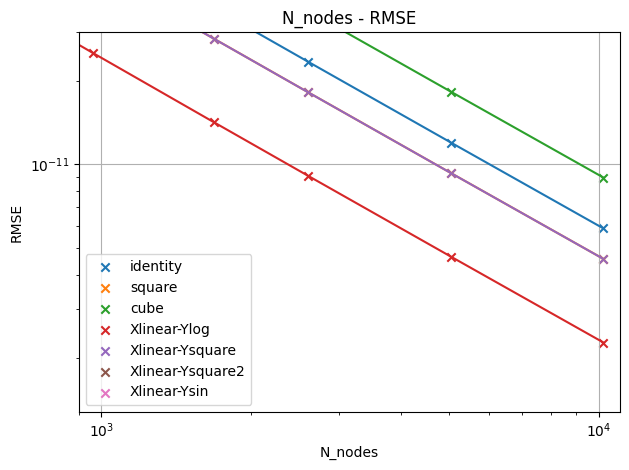

In [ ]:
# Plot df, per alpha
# x: N_nodes(log), y: RMSE
for alpha in df.alpha.unique():
    df_alpha=df[df.alpha==alpha]
    # sort df alpha by N_nodes
    df_alpha=df_alpha.sort_values("N_nodes")
    plt.plot(df_alpha.N_nodes,df_alpha.RMSE)#
    plt.scatter(df_alpha.N_nodes,df_alpha.RMSE,label=alpha,marker='x')
# plt.xlim(1000,15000)
# #plt.ylim(-0.0001,0.01)
# plt.ylim(-0.00001,0.001)
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.xlabel('N_nodes')
plt.ylabel('RMSE')
plt.title('N_nodes - RMSE')
plt.legend()
plt.tight_layout()
plt.savefig("RMSE_evol1_2.png")
plt.xlim(100,11000)
plt.ylim(-1e-12,3e-10)
plt.savefig("RMSE_evol2_2.png")
plt.xlim(900,11000)
plt.ylim(-1e-13,3e-11)
plt.savefig("RMSE_evol3_2.png")
plt.show()
